In [1]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from __future__ import print_function
import numpy
import tensorflow as tf
import tensorflow
from tensorflow import keras
from keras.datasets import mnist
from keras import backend as K
from matplotlib import pyplot as plt
import scipy
from keras.applications import vgg16

from pathlib import Path
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input

2022-11-03 13:35:20.075676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 13:35:20.246567: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-03 13:35:20.899441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/tharci/anaconda3/lib/
2022-11-03 13:35:20.900462: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: c

In [72]:
seed = 123
zoom = 2
downscale_fact = 2

image_height_orig = 720
image_width_orig = 1280

image_height_ds = image_height_orig // downscale_fact
image_width_ds = image_width_orig // downscale_fact

image_height = 224
image_width = 224

images_path = '../images'
batch_size = 8

train_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    validation_split=0.2,
)

train_ds = train_datagen.flow_from_directory(
    images_path,
    target_size=(image_height_ds, image_width_ds),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode=None,
    subset='training',
    # seed=seed,
)

test_ds = train_datagen.flow_from_directory(
    images_path,
    target_size=(image_height_ds, image_width_ds),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode=None,
    subset='validation',
    # seed=seed,
)


def crop_img(img):
    y = np.random.randint(0, img.shape[0] - image_height)
    x = np.random.randint(0, img.shape[1] - image_width)
    return img[y:y+image_height, x:x+image_width]


def preprocess_generator(generator):
    while True:
        images = next(generator)
        images_input = np.zeros((images.shape[0], image_height, image_width, 3))
        images_output = np.zeros((images.shape[0], image_height, image_width, 3))
        for i in range(images.shape[0]):
            cropped_img = crop_img(images[i])
            images_output[i] = cropped_img / 255.
            images_input[i] = cropped_img
            vgg16.preprocess_input(images_input[i])
        yield images_input, images_output


def intput_to_output(images):
    return (images + 128.) / 255.

train_ds_prep = preprocess_generator(train_ds)
test_ds_prep = preprocess_generator(test_ds)

Found 3407 images belonging to 1 classes.
Found 851 images belonging to 1 classes.


Input image constraints: -123.68 151.061
Output image constraints: 0.0 1.0


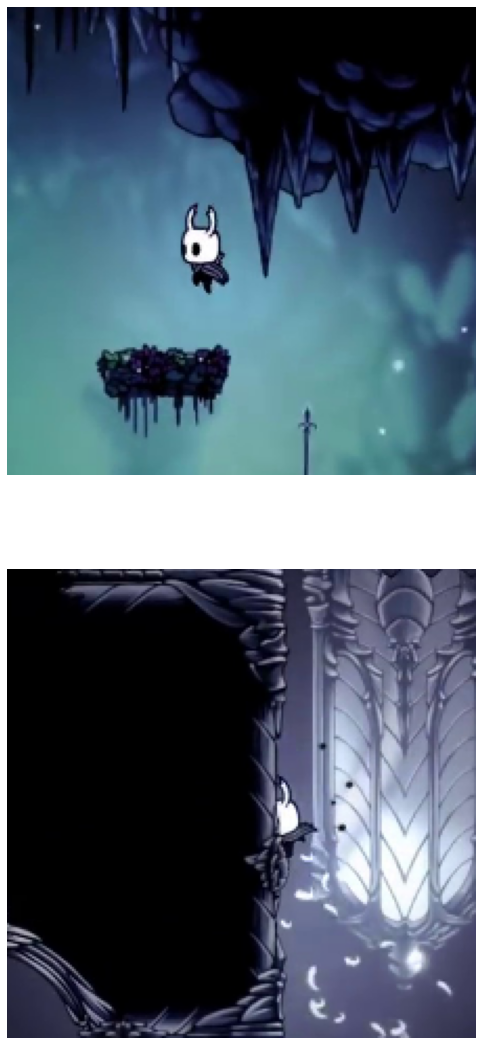

In [73]:
plt.figure(figsize=(50, 50))
images = next(train_ds_prep)
print('Input image constraints:', np.min(images[0]), np.max(images[0]))
print('Output image constraints:', np.min(images[1]), np.max(images[1]))
for i, image in enumerate(images[1][:2]):
    ax = plt.subplot(5, 1, i + 1)
    plt.imshow(image)
    plt.axis("off")

train_ds.reset()

In [76]:

from keras import Sequential, Model
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, UpSampling2D, Conv2D, LeakyReLU, Conv2DTranspose, ZeroPadding2D, BatchNormalization, Dropout, Activation, Add


def create_model_mobilenet():
    conv_base = MobileNet(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

    model = Sequential(conv_base.layers[:-15])

    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu', name='encoded', dtype='float16'))



    model.add(Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(64, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(16, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(16, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(3, kernel_size=(3, 3), strides=(2, 2), activation='sigmoid', padding='same', name='decoded'))

    return model, conv_base


# create_model()[1].summary()
# create_model()[0].summary()

In [77]:
import tensorflow


def ssim_loss(y_true, y_pred):
    return 1 - tensorflow.reduce_mean(tensorflow.image.ssim_multiscale(y_true, y_pred, 1.0, filter_size=3))


model, conv_base = create_model_mobilenet()
# model = create_improved_baseline_model_4x_comp()

# total_num_layers = len(model.layers)
# num_base_layers = len(conv_base.layers)
# print(f"Total number of layers is {total_num_layers}")
# print(f"Number of pretrained base layers is {num_base_layers}")


# for layer in model.layers:
#     layer.trainable = False

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                          
                                                                 
 conv_dw_1_relu (ReLU)       (None, 112, 112, 32)     

In [78]:
# conv_base.summary()

In [79]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.003), loss=ssim_loss)

In [80]:
# Train model
conv_base.trainable = False
model.fit(train_ds_prep,
                validation_data = test_ds_prep,
                steps_per_epoch = train_ds.n // train_ds.batch_size,
                validation_steps = test_ds.n // test_ds.batch_size,
                epochs=50,
                verbose=1)

Epoch 1/50
425/425 [==============================] - 62s 134ms/step - loss: 0.3210 - val_loss: 0.3601
Epoch 2/50
425/425 [==============================] - 57s 132ms/step - loss: 0.1947 - val_loss: 0.2369
Epoch 3/50
425/425 [==============================] - 57s 133ms/step - loss: 0.1778 - val_loss: 0.1959
Epoch 4/50
425/425 [==============================] - 56s 133ms/step - loss: 0.1528 - val_loss: 0.1689
Epoch 5/50
425/425 [==============================] - 57s 133ms/step - loss: 0.1445 - val_loss: 0.1514
Epoch 6/50
425/425 [==============================] - 57s 135ms/step - loss: 0.1450 - val_loss: 0.1522
Epoch 7/50
425/425 [==============================] - 57s 134ms/step - loss: 0.1390 - val_loss: 0.1423
Epoch 8/50
425/425 [==============================] - 58s 136ms/step - loss: 0.1367 - val_loss: 0.1574
Epoch 9/50
425/425 [==============================] - 57s 134ms/step - loss: 0.1246 - val_loss: 0.1245
Epoch 10/50
425/425 [==============================] - 57s 135ms/step - l

In [21]:
# Finding index of encoded layer
layer_names = [layer.name for layer in model.layers]
layer_idx = layer_names.index('encoded')

76


In [81]:
# Fine train

conv_base.trainable = True

# conv_base.trainable = False
# for layer in model.layers[layer_idx - 16:]:
#     layer.trainable = True

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                          
                                                                 
 conv_dw_1_relu (ReLU)       (None, 112, 112, 32)     

In [83]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00006), loss=ssim_loss)

model.fit(train_ds_prep,
                validation_data = test_ds_prep,
                steps_per_epoch = train_ds.n // train_ds.batch_size,
                validation_steps = test_ds.n // test_ds.batch_size,
                epochs=50,
                verbose=1)

Epoch 1/50
425/425 [==============================] - 61s 131ms/step - loss: 0.0588 - val_loss: 0.0624
Epoch 2/50
425/425 [==============================] - 55s 130ms/step - loss: 0.0575 - val_loss: 0.0636
Epoch 3/50
425/425 [==============================] - 55s 130ms/step - loss: 0.0571 - val_loss: 0.0623
Epoch 4/50
425/425 [==============================] - 56s 133ms/step - loss: 0.0580 - val_loss: 0.0623
Epoch 5/50
425/425 [==============================] - 59s 140ms/step - loss: 0.0578 - val_loss: 0.0610
Epoch 6/50
425/425 [==============================] - 60s 141ms/step - loss: 0.0573 - val_loss: 0.0633
Epoch 7/50
425/425 [==============================] - 57s 135ms/step - loss: 0.0579 - val_loss: 0.0608
Epoch 8/50
425/425 [==============================] - 57s 135ms/step - loss: 0.0571 - val_loss: 0.0625
Epoch 9/50
425/425 [==============================] - 57s 134ms/step - loss: 0.0567 - val_loss: 0.0618
Epoch 10/50
425/425 [==============================] - 57s 135ms/step - l

KeyboardInterrupt: 

In [26]:
# model.save('../model-saves/pretrained-v2/')

INFO:tensorflow:Assets written to: ../model-saves/pretrained-v2/assets


INFO:tensorflow:Assets written to: ../model-saves/pretrained-v2/assets


1/1 [==============================] - 1s 1s/step
-123.68 151.061
4.5141982e-10 0.98743665 (4, 224, 224, 3)
[[[0.08675471 0.12000318 0.18138707]
  [0.05171248 0.06218508 0.09734139]
  [0.04822813 0.05537177 0.09117305]
  ...
  [0.12372316 0.13811243 0.20701788]
  [0.125772   0.13948224 0.20828147]
  [0.12104461 0.1349772  0.19772954]]

 [[0.03846813 0.04611737 0.08263343]
  [0.03017827 0.03582229 0.05540041]
  [0.03120076 0.03802007 0.06009387]
  ...
  [0.09999678 0.10947378 0.18107565]
  [0.11457571 0.13205448 0.19756122]
  [0.10095546 0.11845281 0.16735291]]

 [[0.04578128 0.04783735 0.09034297]
  [0.03908366 0.04780765 0.07084271]
  [0.04176188 0.04858473 0.0730647 ]
  ...
  [0.11842486 0.12357955 0.19903937]
  [0.12258359 0.14306808 0.21409161]
  [0.10772672 0.12954172 0.18317391]]

 ...

 [[0.23088637 0.25294825 0.3317175 ]
  [0.25086582 0.2648636  0.3491631 ]
  [0.30132788 0.31464255 0.3900773 ]
  ...
  [0.00754267 0.0115509  0.03046156]
  [0.00954133 0.0143042  0.03433708]
  [0.

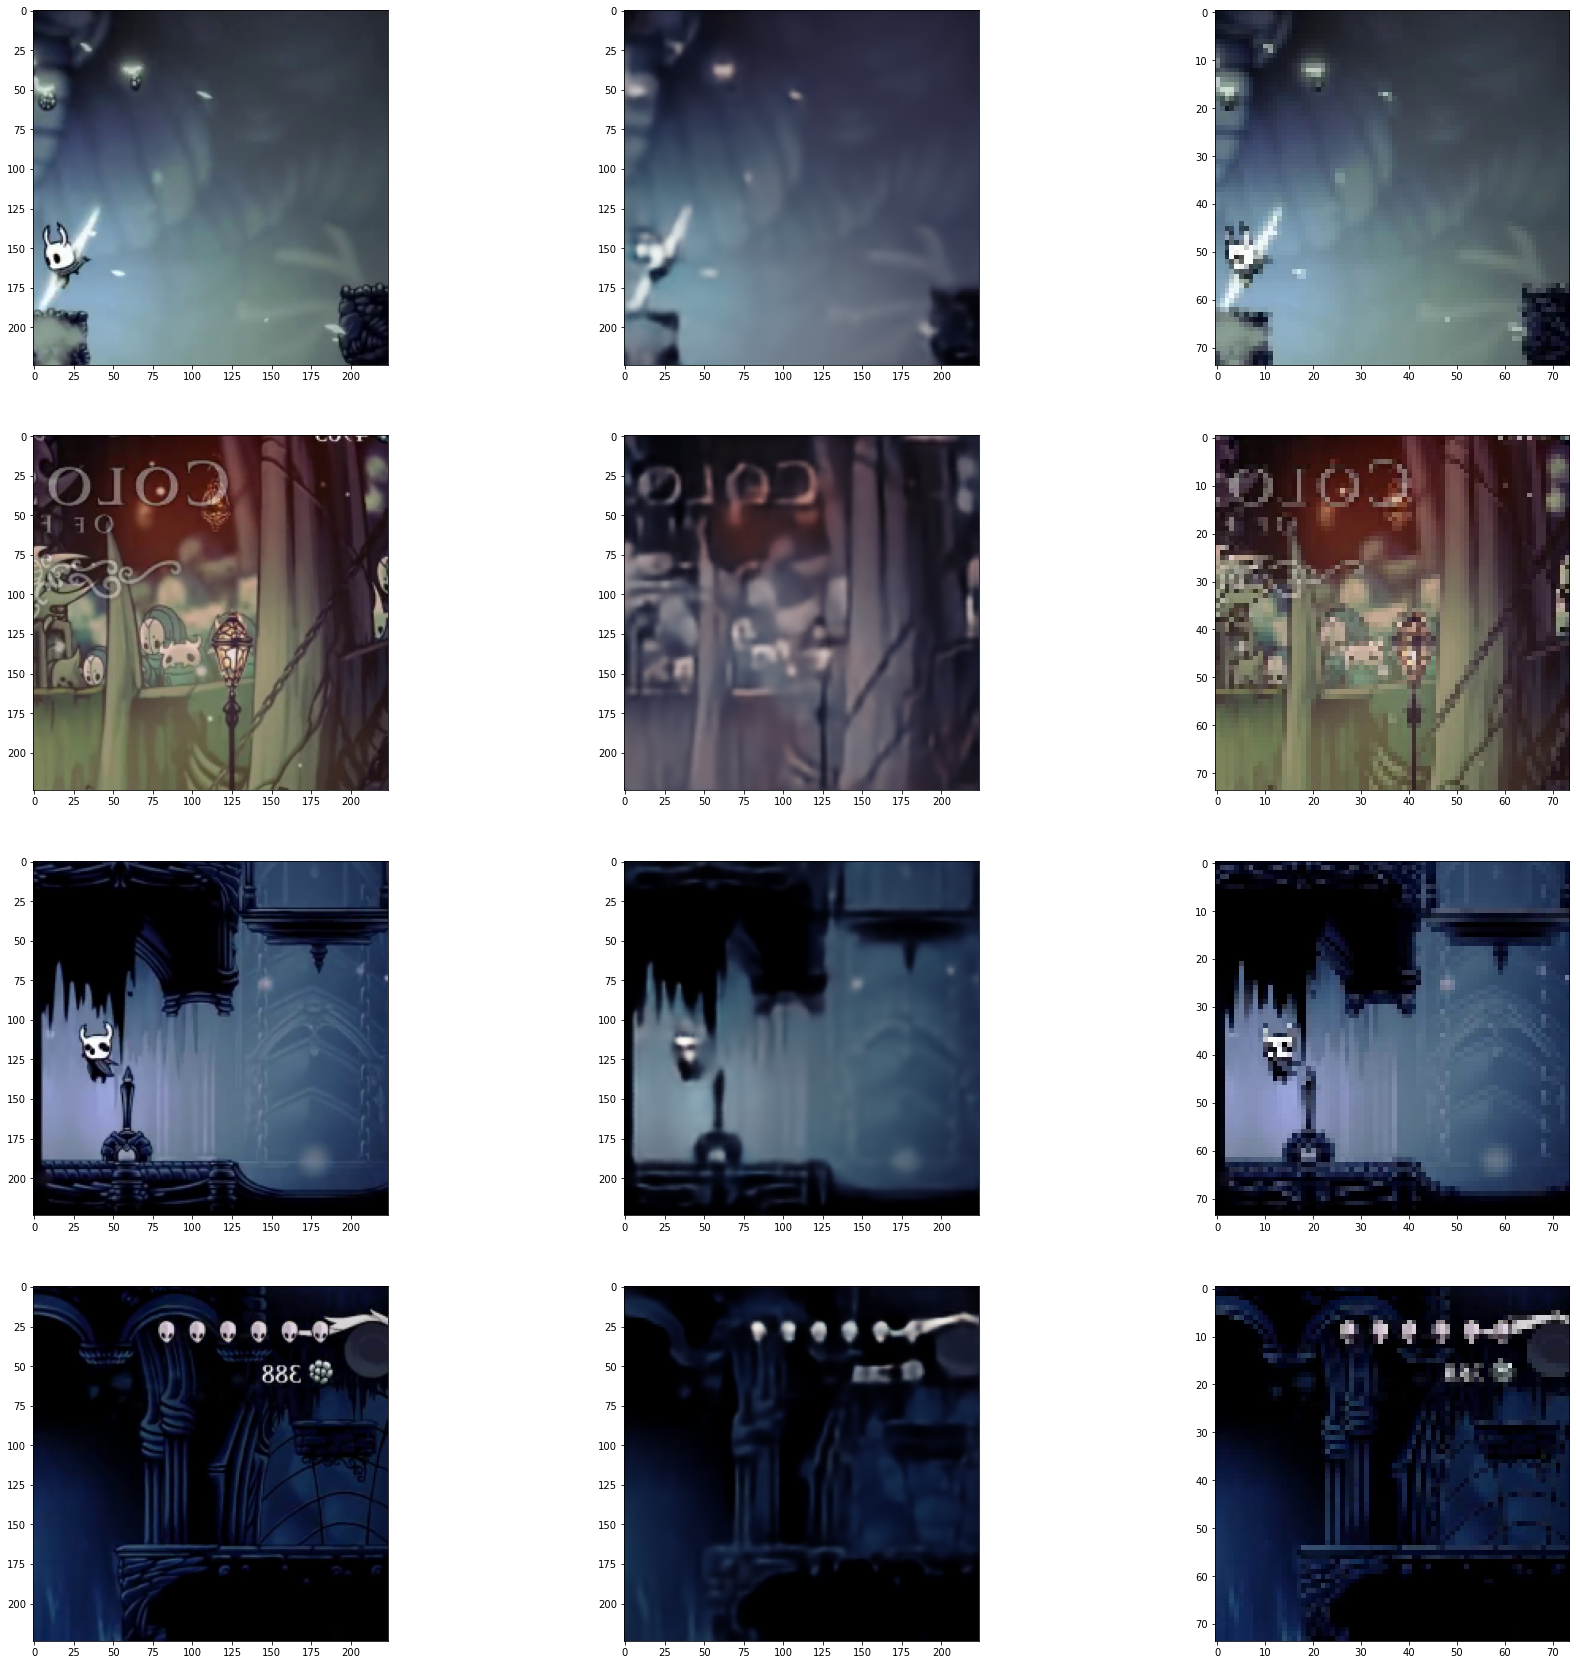

In [84]:
from matplotlib.pyplot import axes
import numpy as np
import cv2

img_number = 4
test_images = next(test_ds_prep)
test_images_input = test_images[0][:img_number]
test_images_output = test_images[1][:img_number]
decoded_imgs = model.predict(test_images_input)

print(np.min(test_images_input), np.max(test_images_input))
print(np.min(decoded_imgs), np.max(decoded_imgs), decoded_imgs.shape)
print(decoded_imgs[0])

fig = plt.figure(figsize=(30, 30))

for i, expected_img, out_img in zip(range(0, img_number, 1), test_images_output, decoded_imgs):
    plt.subplot(img_number, 3, i*3+1)
    plt.imshow(expected_img)
    plt.subplot(img_number, 3, i*3 + 2)
    plt.imshow(out_img)
    plt.subplot(img_number, 3, i*3 + 3)
    rescaled_img = cv2.resize(expected_img, (expected_img.shape[0] // 3, expected_img.shape[1] // 3))
    # manual_compression = tensorflow.cast(in_img*255. ,tensorflow.int32)
    # manual_compression = manual_compression - (manual_compression % 64)
    # manual_compression = tensorflow.cast(manual_compression ,tensorflow.float32)
    # manual_compression = tensorflow.cast(manual_compression/255. ,tensorflow.float32)
    plt.imshow(rescaled_img)
    # print(f'Image({i}) ms-ssim={ssim_loss(in_img, out_img):5.4f}, mae={np.mean(np.abs(in_img - out_img)):5.4f}, ms-ssim(manual)={ssim_loss(in_img, manual_compression):5.4f}, mae(manual)={np.mean(np.abs(in_img - manual_compression)):5.4f}')